# Demo of the BGTM on 2-Dimensional Joe-Copula

In this demonstration we show how the GTM can be used to learn a probability distribution from synthetic data sampled from a 2 dimensional Joe copula.
To sample synthetic copula data we use the [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib) library.
Fore more details on copulas we refer to the Book [Analyzing Dependent Data with Vine Copulas](https://link.springer.com/book/10.1007/978-3-030-13785-4) for an comprehensive introduction to copulas and vine copulas.

In [1]:
from pathlib import Path
import sys

# Add project root (parent of "demos") to sys.path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))


from gtm import *

# Sample Copulas Package
import pyvinecopulib as pv

# Other Stuff
import numpy as np
import torch
from torch.utils.data import DataLoader
from demos.dataset_helpers import Generic_Dataset

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Sample Synthetic Copula Data and Compute Likelihoods

We sample data from a Joe Copula and add Gaussian marginals. Feel free to exchange the copula parameter, the rotation or even the copula itsself.
The list of copulas can be found with `help(pv.Bicop)`.

Notice we use Sklars Theorem to compute the density of the joint copula and Gaussian marginals density.

In [2]:
copula_pv = pv.Bicop(family=pv.BicopFamily.joe, parameters=np.array([[2.5]]), rotation=90)

# Train
N_train = 2000
simulated_data_uniform_train = copula_pv.simulate(n=N_train)
simulated_data_train = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_train)).float()

# Validate
N_validate = 2000
simulated_data_uniform_validate = copula_pv.simulate(n=N_validate)
simulated_data_validate = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_validate)).float()

# Test
N_test = 20000
simulated_data_uniform_test = copula_pv.simulate(n=N_test)
simulated_data_test = torch.distributions.Normal(0,1).icdf(torch.tensor(simulated_data_uniform_test)).float()

In [3]:
loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
loglik_true_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
loglik_true_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_test)).sum(1)
loglik_true_test = torch.tensor(loglik_copula) + log_marginals

/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_97625/2085715786.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_train)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_97625/2085715786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_marginals = torch.distributions.Normal(0,1).log_prob(torch.tensor(simulated_data_validate)).sum(1)
/var/folders/_p/ttn2qcdj23jdpltyffhwq9pr0000gn/T/ipykernel_97625/2085715786.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True)

We further estimate the copula on the synthetic data to get an oracle denisity estimator. Hence an estimator that knows the true underlying structure and merely estiamtes the model parameters.

In [4]:
copula_pv_est = pv.Bicop(family=pv.BicopFamily.joe, rotation=90)
copula_pv_est.fit(simulated_data_uniform_train)
means = simulated_data_train.mean(0)
vars = simulated_data_train.var(0)

In [5]:
loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_train))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_train).sum(1)
loglik_true_est_train = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_validate))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_validate).sum(1)
loglik_true_est_validate = torch.tensor(loglik_copula) + log_marginals

loglik_copula = np.log(copula_pv_est.pdf(simulated_data_uniform_test))
log_marginals = torch.distributions.Normal(means,vars).log_prob(simulated_data_test).sum(1)
loglik_true_est_test = torch.tensor(loglik_copula) + log_marginals

The package is implemented to use Dataloaders for training. This is done to accommodate larger datasets trained batch wise as is common in deep learning and bioinformatics applications. Feel free to use the [`Generic_Dataset`](demos/dataset_helpers.py) class to easily adjust it to your data. For full data training, thus whithout batches simply seet the `batch_size` arguement in the `DataLoader` to the data size as we do in this example

In [6]:
# Create dataset and DataLoader
dataset_train = Generic_Dataset(simulated_data_train)
dataloader_train = DataLoader(dataset_train, batch_size=N_train)

dataset_validate = Generic_Dataset(simulated_data_validate)
dataloader_validate = DataLoader(dataset_validate, batch_size=N_validate)

### 2. Define Model

We define a simple GTM model with the standard parameters.
Notable custamizable parameter are: 
- The dimensionality of the data `number_variables`
- The number of transformation layers `num_trans_layers`, either 0 or 1.
- The number of decorrelation layers `num_decorr_layers`, typically 3 or more. 
- the spline to use for the transformation layer splines `spline_transformation` and the decorrelation layer splines `spline_decorrelation`.  The two types of layers: P-Splines (`bspline`) or bernstein polynomials (`bernstein`).
- The degrees of the splines, representing there flexibility, being `degree_decorrelation` for the decorrelation layer splines and `degree_transformations` for the transformation layer. When using `bspline`, then `degree_transformations` can also be given a list with varying degrees for each dimension of the data.
- `transformation_spline_range`sets the outer borders for the transformation layer splines, this dependends on the input data and should be set a bit wider then the actual data.
- `device` either `cpu`or `cuda`


In [7]:
hyperparameters = {
    "transformation": {
    "sigma_a": 2.1, "sigma_b": 1e6,        #Ignored not used
    "RW2": { "tau_a": 2.0, "tau_b": 5.0 },  #E[λ_T] = 0.40  (smooth but not stiff)
    "RW1": { "tau_a": 10.0,"tau_b": 15.0 }  #Ignored not used
    },
    "decorrelation": {
    "sigma_a": 2.1, "sigma_b": 1e6,              # mean σ² = very small close to 0 (weak)
    "RW2": { "tau_a": 1.5, "tau_b": 30.0 },      # E[κ2] ≈ 0.05   (weak curvature smoothing)
    "RW1": { "tau_a": 1.5, "tau_b": 15.0 },      # E[κ1] ≈ 0.10   (light shrink to linear)
    }
}



model = GTM(
    number_variables=2,
    number_transformation_layers=1,
    number_decorrelation_layers=3,
    degree_transformations=10,
    degree_decorrelation=40,
    spline_transformation="bspline",
    spline_decorrelation="bspline",
    transformation_spline_range=(-10, 10),
    device="cpu",
    ## NEW ARGUMENTS ##
    inference = 'bayesian',
    hyperparameter=hyperparameters
    )


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
_=model

The GTM class contains a number of plotting functions so that standard analysis can be done soley with the model:

In [8]:
#model.plot_marginals(simulated_data_train)

### 3. Hyperparameter Tune and Train Model

To find the optimal penalties one uses the `hyperparameter_tune_penalties` function. Then using the optimal penalties one can train the model.

The training can be done by pretraining the marginal transformations with `pretrain_tranformation_layer` and then training jointly with `train`.
In general empirically we found that pretraining reduces training time and improves results allthough direct joint training also works.

Hyperparameter tuning can be done for the penalties `penvalueridge, penfirstridge , pensecondridge, ctm_pensecondridge, lambda_penalty_params` by passing the arguement `"sample"`.
If a fixed number is passed, typically zero, then for that penalty no hyperparameter drawing is done and the fixed values is used.


In [9]:
output = model.fit_bayes(
                train_dataloader=dataloader_train,
                validate_dataloader=dataloader_validate,
                hyperparameters=None,
                iterations=1000,
                verbose=True,
                lr=0.01,
                mcmc_sample_train=8,            # will ramp
                mcmc_sample_val=32,             # fixed & larger for stable eval
                mc_ramp_every=10,               # 4→8→16→32 at epochs 25/50/75
                mc_ramp_max=64,
                patience_val=15,                # early-stop patience
                min_delta=0.001,                # ~0.1% absolute of your loss scale
                rho_lr_multiplier=2,          # slightly faster variance adaption (optional)
                sched_factor=0.5, sched_patience=6, sched_threshold=1e-4,
            )

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
  0%|          | 0/1000 [00:00<?, ?it/s]/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_splines/bspline_prediction_vectorized.py:595: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3641.)
  x=input_a_clone.T, t=knots.T, c=params_a.

[1/1000] train=235.4495  val=235.6452  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0510  σmin=0.0510  σmax=0.0510


  0%|          | 2/1000 [00:01<14:59,  1.11it/s]

[2/1000] train=232.9750  val=232.7139  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0520  σmin=0.0520  σmax=0.0520


  0%|          | 3/1000 [00:02<16:06,  1.03it/s]

[3/1000] train=227.0051  val=229.7849  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0530  σmin=0.0530  σmax=0.0530


  0%|          | 4/1000 [00:03<14:28,  1.15it/s]

[4/1000] train=222.9282  val=226.8576  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0541  σmin=0.0541  σmax=0.0541


  0%|          | 5/1000 [00:04<13:28,  1.23it/s]

[5/1000] train=222.9444  val=223.9317  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0551  σmin=0.0551  σmax=0.0551


  1%|          | 6/1000 [00:05<13:46,  1.20it/s]

[6/1000] train=223.6613  val=221.0079  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0562  σmin=0.0562  σmax=0.0562


  1%|          | 7/1000 [00:05<13:03,  1.27it/s]

[7/1000] train=217.1140  val=218.0863  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0573  σmin=0.0573  σmax=0.0573


  1%|          | 8/1000 [00:06<14:27,  1.14it/s]

[8/1000] train=217.2523  val=215.1667  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0584  σmin=0.0584  σmax=0.0584


  1%|          | 9/1000 [00:08<16:32,  1.00s/it]

[9/1000] train=214.0183  val=212.2491  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0596  σmin=0.0596  σmax=0.0596


  1%|          | 10/1000 [00:09<18:41,  1.13s/it]

[10/1000] train=207.2082  val=209.3332  S_train=8 S_val=32 lr=[0.01, 0.02]σ̄=0.0607  σmin=0.0607  σmax=0.0607


  1%|          | 11/1000 [00:10<18:39,  1.13s/it]

[11/1000] train=211.5530  val=206.4192  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0619  σmin=0.0619  σmax=0.0619


  1%|          | 12/1000 [00:11<18:02,  1.10s/it]

[12/1000] train=207.8155  val=203.5070  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0631  σmin=0.0631  σmax=0.0631


  1%|▏         | 13/1000 [00:12<17:25,  1.06s/it]

[13/1000] train=203.8196  val=200.5962  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0644  σmin=0.0644  σmax=0.0644


  1%|▏         | 14/1000 [00:13<15:58,  1.03it/s]

[14/1000] train=207.6740  val=197.6875  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0656  σmin=0.0656  σmax=0.0656


  2%|▏         | 15/1000 [00:14<15:06,  1.09it/s]

[15/1000] train=196.3269  val=194.7810  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0669  σmin=0.0669  σmax=0.0669


  2%|▏         | 16/1000 [00:15<14:51,  1.10it/s]

[16/1000] train=193.8984  val=191.8764  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0682  σmin=0.0682  σmax=0.0682


  2%|▏         | 17/1000 [00:15<14:10,  1.16it/s]

[17/1000] train=194.0129  val=188.9740  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0696  σmin=0.0696  σmax=0.0696


  2%|▏         | 18/1000 [00:16<13:46,  1.19it/s]

[18/1000] train=185.4866  val=186.0740  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0709  σmin=0.0709  σmax=0.0709


  2%|▏         | 19/1000 [00:17<13:48,  1.18it/s]

[19/1000] train=183.1208  val=183.1765  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0723  σmin=0.0723  σmax=0.0723


  2%|▏         | 20/1000 [00:18<13:25,  1.22it/s]

[20/1000] train=183.0073  val=180.2814  S_train=16 S_val=32 lr=[0.01, 0.02]σ̄=0.0737  σmin=0.0737  σmax=0.0737


  2%|▏         | 21/1000 [00:19<17:03,  1.05s/it]

[21/1000] train=180.2755  val=177.3887  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0751  σmin=0.0751  σmax=0.0751


  2%|▏         | 22/1000 [00:20<16:56,  1.04s/it]

[22/1000] train=177.9295  val=174.4977  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0766  σmin=0.0766  σmax=0.0766


  2%|▏         | 23/1000 [00:21<16:30,  1.01s/it]

[23/1000] train=173.5283  val=171.6082  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0781  σmin=0.0781  σmax=0.0781


  2%|▏         | 24/1000 [00:22<15:58,  1.02it/s]

[24/1000] train=168.4672  val=168.7209  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0796  σmin=0.0796  σmax=0.0796


  2%|▎         | 25/1000 [00:23<15:38,  1.04it/s]

[25/1000] train=168.9121  val=165.8363  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0811  σmin=0.0811  σmax=0.0812


  3%|▎         | 26/1000 [00:24<15:18,  1.06it/s]

[26/1000] train=163.9054  val=162.9543  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0827  σmin=0.0827  σmax=0.0827


  3%|▎         | 27/1000 [00:25<15:04,  1.08it/s]

[27/1000] train=161.7908  val=160.0748  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0843  σmin=0.0843  σmax=0.0843


  3%|▎         | 28/1000 [00:26<14:54,  1.09it/s]

[28/1000] train=159.4312  val=157.1977  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0860  σmin=0.0859  σmax=0.0860


  3%|▎         | 29/1000 [00:27<14:46,  1.10it/s]

[29/1000] train=153.3382  val=154.3230  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0876  σmin=0.0876  σmax=0.0876


  3%|▎         | 30/1000 [00:28<15:22,  1.05it/s]

[30/1000] train=155.0631  val=151.4506  S_train=32 S_val=32 lr=[0.01, 0.02]σ̄=0.0893  σmin=0.0893  σmax=0.0893


  3%|▎         | 31/1000 [00:30<21:39,  1.34s/it]

[31/1000] train=150.5561  val=148.5810  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0910  σmin=0.0910  σmax=0.0910


  3%|▎         | 32/1000 [00:34<34:55,  2.16s/it]

[32/1000] train=150.1239  val=145.7142  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0928  σmin=0.0928  σmax=0.0928


  3%|▎         | 33/1000 [00:37<37:12,  2.31s/it]

[33/1000] train=145.4221  val=142.8508  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0946  σmin=0.0946  σmax=0.0946


  3%|▎         | 34/1000 [00:40<41:10,  2.56s/it]

[34/1000] train=142.5775  val=139.9898  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0964  σmin=0.0964  σmax=0.0964


  4%|▎         | 35/1000 [00:43<41:25,  2.58s/it]

[35/1000] train=137.7702  val=137.1308  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.0983  σmin=0.0982  σmax=0.0983


  4%|▎         | 36/1000 [00:45<38:58,  2.43s/it]

[36/1000] train=138.8699  val=134.2743  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1001  σmin=0.1001  σmax=0.1002


  4%|▎         | 37/1000 [00:46<35:34,  2.22s/it]

[37/1000] train=134.1514  val=131.4198  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1021  σmin=0.1020  σmax=0.1021


  4%|▍         | 38/1000 [00:48<34:11,  2.13s/it]

[38/1000] train=130.1900  val=128.5681  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1040  σmin=0.1040  σmax=0.1040


  4%|▍         | 39/1000 [00:50<33:46,  2.11s/it]

[39/1000] train=128.7432  val=125.7194  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1060  σmin=0.1060  σmax=0.1060


  4%|▍         | 40/1000 [00:52<33:37,  2.10s/it]

[40/1000] train=125.0324  val=122.8738  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1081  σmin=0.1080  σmax=0.1081


  4%|▍         | 41/1000 [00:54<32:53,  2.06s/it]

[41/1000] train=123.4843  val=120.0316  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1101  σmin=0.1101  σmax=0.1101


  4%|▍         | 42/1000 [00:56<32:09,  2.01s/it]

[42/1000] train=119.2535  val=117.1927  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1122  σmin=0.1122  σmax=0.1122


  4%|▍         | 43/1000 [00:58<30:50,  1.93s/it]

[43/1000] train=116.8008  val=114.3569  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1144  σmin=0.1143  σmax=0.1144


  4%|▍         | 44/1000 [01:00<29:01,  1.82s/it]

[44/1000] train=113.0449  val=111.5240  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1165  σmin=0.1165  σmax=0.1166


  4%|▍         | 45/1000 [01:02<29:50,  1.88s/it]

[45/1000] train=110.9326  val=108.6936  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1188  σmin=0.1187  σmax=0.1188


  5%|▍         | 46/1000 [01:03<29:27,  1.85s/it]

[46/1000] train=109.4629  val=105.8661  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1210  σmin=0.1209  σmax=0.1210


  5%|▍         | 47/1000 [01:05<30:01,  1.89s/it]

[47/1000] train=104.8745  val=103.0425  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1233  σmin=0.1232  σmax=0.1233


  5%|▍         | 48/1000 [01:08<31:19,  1.97s/it]

[48/1000] train=103.2121  val=100.2229  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1257  σmin=0.1256  σmax=0.1257


  5%|▍         | 49/1000 [01:10<32:02,  2.02s/it]

[49/1000] train=100.8111  val=97.4063  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1281  σmin=0.1279  σmax=0.1281


  5%|▌         | 50/1000 [01:12<32:18,  2.04s/it]

[50/1000] train=96.9516  val=94.5931  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1305  σmin=0.1303  σmax=0.1305


  5%|▌         | 51/1000 [01:14<32:39,  2.06s/it]

[51/1000] train=95.0080  val=91.7831  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1329  σmin=0.1328  σmax=0.1330


  5%|▌         | 52/1000 [01:16<32:32,  2.06s/it]

[52/1000] train=90.7220  val=88.9766  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1355  σmin=0.1353  σmax=0.1355


  5%|▌         | 53/1000 [01:18<31:34,  2.00s/it]

[53/1000] train=89.3907  val=86.1736  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1380  σmin=0.1378  σmax=0.1380


  5%|▌         | 54/1000 [01:20<32:48,  2.08s/it]

[54/1000] train=86.0153  val=83.3743  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1406  σmin=0.1404  σmax=0.1406


  6%|▌         | 55/1000 [01:22<32:46,  2.08s/it]

[55/1000] train=82.8937  val=80.5787  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1433  σmin=0.1431  σmax=0.1433


  6%|▌         | 56/1000 [01:24<32:44,  2.08s/it]

[56/1000] train=78.6449  val=77.7870  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1460  σmin=0.1457  σmax=0.1460


  6%|▌         | 57/1000 [01:27<34:24,  2.19s/it]

[57/1000] train=75.1344  val=74.9991  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1487  σmin=0.1485  σmax=0.1487


  6%|▌         | 58/1000 [01:29<33:04,  2.11s/it]

[58/1000] train=75.1372  val=72.2151  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1515  σmin=0.1512  σmax=0.1515


  6%|▌         | 59/1000 [01:30<31:08,  1.99s/it]

[59/1000] train=70.8262  val=69.4350  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1543  σmin=0.1540  σmax=0.1543


  6%|▌         | 60/1000 [01:33<32:34,  2.08s/it]

[60/1000] train=69.2414  val=66.6589  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1572  σmin=0.1569  σmax=0.1572


  6%|▌         | 61/1000 [01:34<31:30,  2.01s/it]

[61/1000] train=63.3789  val=63.8870  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1601  σmin=0.1598  σmax=0.1602


  6%|▌         | 62/1000 [01:37<31:33,  2.02s/it]

[62/1000] train=62.3022  val=61.1193  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1631  σmin=0.1628  σmax=0.1631


  6%|▋         | 63/1000 [01:39<31:55,  2.04s/it]

[63/1000] train=59.7966  val=58.3563  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1662  σmin=0.1658  σmax=0.1662


  6%|▋         | 64/1000 [01:40<30:00,  1.92s/it]

[64/1000] train=57.9283  val=55.5975  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1692  σmin=0.1689  σmax=0.1693


  6%|▋         | 65/1000 [01:42<28:29,  1.83s/it]

[65/1000] train=55.6056  val=52.8424  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1724  σmin=0.1720  σmax=0.1724


  7%|▋         | 66/1000 [01:44<27:42,  1.78s/it]

[66/1000] train=52.4983  val=50.0912  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1756  σmin=0.1751  σmax=0.1756


  7%|▋         | 67/1000 [01:45<26:39,  1.71s/it]

[67/1000] train=49.8771  val=47.3451  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1788  σmin=0.1783  σmax=0.1789


  7%|▋         | 68/1000 [01:47<25:43,  1.66s/it]

[68/1000] train=48.0891  val=44.6034  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1821  σmin=0.1816  σmax=0.1822


  7%|▋         | 69/1000 [01:48<25:08,  1.62s/it]

[69/1000] train=42.9194  val=41.8662  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1855  σmin=0.1849  σmax=0.1855


  7%|▋         | 70/1000 [01:50<25:26,  1.64s/it]

[70/1000] train=40.4408  val=39.1337  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1889  σmin=0.1883  σmax=0.1889


  7%|▋         | 71/1000 [01:51<25:28,  1.65s/it]

[71/1000] train=37.5134  val=36.4059  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1924  σmin=0.1917  σmax=0.1924


  7%|▋         | 72/1000 [01:53<25:09,  1.63s/it]

[72/1000] train=37.2774  val=33.6829  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1959  σmin=0.1952  σmax=0.1959


  7%|▋         | 73/1000 [01:55<25:14,  1.63s/it]

[73/1000] train=32.8633  val=30.9655  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.1995  σmin=0.1987  σmax=0.1995


  7%|▋         | 74/1000 [01:57<29:17,  1.90s/it]

[74/1000] train=30.7912  val=28.2544  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2031  σmin=0.2023  σmax=0.2032


  8%|▊         | 75/1000 [02:01<35:54,  2.33s/it]

[75/1000] train=28.1917  val=25.5472  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2068  σmin=0.2059  σmax=0.2069


  8%|▊         | 76/1000 [02:03<35:33,  2.31s/it]

[76/1000] train=23.2230  val=22.8456  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2106  σmin=0.2096  σmax=0.2107


  8%|▊         | 77/1000 [02:05<35:06,  2.28s/it]

[77/1000] train=24.0447  val=20.1486  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2144  σmin=0.2134  σmax=0.2145


  8%|▊         | 78/1000 [02:07<32:54,  2.14s/it]

[78/1000] train=20.6863  val=17.4558  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2183  σmin=0.2172  σmax=0.2184


  8%|▊         | 79/1000 [02:09<31:24,  2.05s/it]

[79/1000] train=15.7996  val=14.7667  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2223  σmin=0.2211  σmax=0.2224


  8%|▊         | 80/1000 [02:10<30:09,  1.97s/it]

[80/1000] train=14.4907  val=12.0834  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2263  σmin=0.2250  σmax=0.2264


  8%|▊         | 81/1000 [02:12<29:43,  1.94s/it]

[81/1000] train=10.3827  val=9.4077  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2304  σmin=0.2290  σmax=0.2305


  8%|▊         | 82/1000 [02:14<29:52,  1.95s/it]

[82/1000] train=7.7804  val=6.7386  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2345  σmin=0.2331  σmax=0.2346


  8%|▊         | 83/1000 [02:16<29:33,  1.93s/it]

[83/1000] train=6.8909  val=4.0754  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2387  σmin=0.2372  σmax=0.2388


  8%|▊         | 84/1000 [02:18<28:59,  1.90s/it]

[84/1000] train=2.9041  val=1.4167  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2430  σmin=0.2414  σmax=0.2431


  8%|▊         | 85/1000 [02:20<28:50,  1.89s/it]

[85/1000] train=1.2414  val=-1.2377  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2474  σmin=0.2456  σmax=0.2475


  9%|▊         | 86/1000 [02:22<28:18,  1.86s/it]

[86/1000] train=-3.4266  val=-3.8867  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2518  σmin=0.2499  σmax=0.2519


  9%|▊         | 87/1000 [02:24<28:10,  1.85s/it]

[87/1000] train=-5.4438  val=-6.5289  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2563  σmin=0.2543  σmax=0.2564


  9%|▉         | 88/1000 [02:25<27:50,  1.83s/it]

[88/1000] train=-8.3007  val=-9.1638  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2608  σmin=0.2587  σmax=0.2610


  9%|▉         | 89/1000 [02:27<29:05,  1.92s/it]

[89/1000] train=-8.7294  val=-11.7928  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2655  σmin=0.2632  σmax=0.2656


  9%|▉         | 90/1000 [02:29<28:29,  1.88s/it]

[90/1000] train=-14.0138  val=-14.4158  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2702  σmin=0.2678  σmax=0.2703


  9%|▉         | 91/1000 [02:31<28:00,  1.85s/it]

[91/1000] train=-15.0826  val=-17.0339  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2749  σmin=0.2724  σmax=0.2751


  9%|▉         | 92/1000 [02:33<27:44,  1.83s/it]

[92/1000] train=-17.1765  val=-19.6465  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2798  σmin=0.2771  σmax=0.2800


  9%|▉         | 93/1000 [02:35<27:31,  1.82s/it]

[93/1000] train=-20.6012  val=-22.2523  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2847  σmin=0.2819  σmax=0.2849


  9%|▉         | 94/1000 [02:36<27:43,  1.84s/it]

[94/1000] train=-21.2638  val=-24.8524  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2897  σmin=0.2867  σmax=0.2899


 10%|▉         | 95/1000 [02:38<27:26,  1.82s/it]

[95/1000] train=-26.5780  val=-27.4459  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2947  σmin=0.2915  σmax=0.2950


 10%|▉         | 96/1000 [02:40<27:16,  1.81s/it]

[96/1000] train=-27.3208  val=-30.0338  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.2999  σmin=0.2965  σmax=0.3001


 10%|▉         | 97/1000 [02:42<27:16,  1.81s/it]

[97/1000] train=-29.6660  val=-32.6146  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3051  σmin=0.3015  σmax=0.3054


 10%|▉         | 98/1000 [02:44<27:08,  1.81s/it]

[98/1000] train=-33.4400  val=-35.1880  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3104  σmin=0.3066  σmax=0.3107


 10%|▉         | 99/1000 [02:45<26:58,  1.80s/it]

[99/1000] train=-34.5482  val=-37.7543  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3158  σmin=0.3118  σmax=0.3161


 10%|█         | 100/1000 [02:47<26:47,  1.79s/it]

[100/1000] train=-38.2591  val=-40.3127  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3212  σmin=0.3170  σmax=0.3215


 10%|█         | 101/1000 [02:49<26:38,  1.78s/it]

[101/1000] train=-41.1174  val=-42.8631  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3268  σmin=0.3223  σmax=0.3271


 10%|█         | 102/1000 [02:51<28:21,  1.89s/it]

[102/1000] train=-42.7568  val=-45.4048  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3324  σmin=0.3277  σmax=0.3327


 10%|█         | 103/1000 [02:53<28:09,  1.88s/it]

[103/1000] train=-46.0415  val=-47.9396  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3381  σmin=0.3331  σmax=0.3384


 10%|█         | 104/1000 [02:55<27:54,  1.87s/it]

[104/1000] train=-47.4702  val=-50.4688  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3439  σmin=0.3386  σmax=0.3442


 10%|█         | 105/1000 [02:57<27:23,  1.84s/it]

[105/1000] train=-52.0416  val=-52.9912  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3497  σmin=0.3441  σmax=0.3501


 11%|█         | 106/1000 [02:58<26:56,  1.81s/it]

[106/1000] train=-54.5788  val=-55.5060  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3557  σmin=0.3498  σmax=0.3561


 11%|█         | 107/1000 [03:00<26:37,  1.79s/it]

[107/1000] train=-55.8158  val=-58.0126  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3617  σmin=0.3555  σmax=0.3621


 11%|█         | 108/1000 [03:02<26:21,  1.77s/it]

[108/1000] train=-59.6638  val=-60.5114  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3678  σmin=0.3612  σmax=0.3683


 11%|█         | 109/1000 [03:04<26:11,  1.76s/it]

[109/1000] train=-61.2055  val=-63.0032  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3740  σmin=0.3671  σmax=0.3745


 11%|█         | 110/1000 [03:05<26:11,  1.77s/it]

[110/1000] train=-62.8838  val=-65.4860  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3803  σmin=0.3729  σmax=0.3808


 11%|█         | 111/1000 [03:07<26:03,  1.76s/it]

[111/1000] train=-64.9166  val=-67.9601  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3866  σmin=0.3789  σmax=0.3872


 11%|█         | 112/1000 [03:09<26:25,  1.79s/it]

[112/1000] train=-68.0886  val=-70.4238  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3931  σmin=0.3849  σmax=0.3937


 11%|█▏        | 113/1000 [03:11<26:25,  1.79s/it]

[113/1000] train=-70.5069  val=-72.8804  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.3996  σmin=0.3910  σmax=0.4003


 11%|█▏        | 114/1000 [03:13<27:43,  1.88s/it]

[114/1000] train=-72.7047  val=-75.3283  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4063  σmin=0.3972  σmax=0.4069


 12%|█▏        | 115/1000 [03:15<27:55,  1.89s/it]

[115/1000] train=-76.7025  val=-77.7682  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4130  σmin=0.4035  σmax=0.4137


 12%|█▏        | 116/1000 [03:16<27:18,  1.85s/it]

[116/1000] train=-77.5439  val=-80.1983  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4198  σmin=0.4099  σmax=0.4205


 12%|█▏        | 117/1000 [03:18<26:52,  1.83s/it]

[117/1000] train=-80.7712  val=-82.6206  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4267  σmin=0.4163  σmax=0.4275


 12%|█▏        | 118/1000 [03:20<26:37,  1.81s/it]

[118/1000] train=-82.8147  val=-85.0383  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4337  σmin=0.4228  σmax=0.4345


 12%|█▏        | 119/1000 [03:22<26:24,  1.80s/it]

[119/1000] train=-86.0230  val=-87.4482  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4408  σmin=0.4294  σmax=0.4416


 12%|█▏        | 120/1000 [03:24<26:19,  1.79s/it]

[120/1000] train=-88.6669  val=-89.8525  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4480  σmin=0.4360  σmax=0.4488


 12%|█▏        | 121/1000 [03:25<26:37,  1.82s/it]

[121/1000] train=-91.4978  val=-92.2509  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4552  σmin=0.4428  σmax=0.4561


 12%|█▏        | 122/1000 [03:27<26:17,  1.80s/it]

[122/1000] train=-93.3763  val=-94.6411  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4626  σmin=0.4496  σmax=0.4635


 12%|█▏        | 123/1000 [03:29<26:04,  1.78s/it]

[123/1000] train=-94.5688  val=-97.0195  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4700  σmin=0.4564  σmax=0.4710


 12%|█▏        | 124/1000 [03:31<25:55,  1.78s/it]

[124/1000] train=-98.6710  val=-99.3896  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4776  σmin=0.4633  σmax=0.4786


 12%|█▎        | 125/1000 [03:32<25:49,  1.77s/it]

[125/1000] train=-100.2918  val=-101.7502  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4852  σmin=0.4702  σmax=0.4863


 13%|█▎        | 126/1000 [03:35<27:15,  1.87s/it]

[126/1000] train=-101.8971  val=-104.0988  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.4929  σmin=0.4772  σmax=0.4941


 13%|█▎        | 127/1000 [03:36<26:47,  1.84s/it]

[127/1000] train=-105.4843  val=-106.4362  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5008  σmin=0.4843  σmax=0.5020


 13%|█▎        | 128/1000 [03:38<26:21,  1.81s/it]

[128/1000] train=-106.9144  val=-108.7652  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5087  σmin=0.4913  σmax=0.5100


 13%|█▎        | 129/1000 [03:40<26:06,  1.80s/it]

[129/1000] train=-108.6348  val=-111.0865  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5167  σmin=0.4984  σmax=0.5181


 13%|█▎        | 130/1000 [03:42<26:31,  1.83s/it]

[130/1000] train=-111.6761  val=-113.3974  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5248  σmin=0.5056  σmax=0.5263


 13%|█▎        | 131/1000 [03:43<26:13,  1.81s/it]

[131/1000] train=-116.2068  val=-115.6966  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5330  σmin=0.5129  σmax=0.5346


 13%|█▎        | 132/1000 [03:45<26:00,  1.80s/it]

[132/1000] train=-115.6034  val=-117.9849  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5413  σmin=0.5202  σmax=0.5429


 13%|█▎        | 133/1000 [03:47<25:41,  1.78s/it]

[133/1000] train=-120.7283  val=-120.2589  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5497  σmin=0.5274  σmax=0.5514


 13%|█▎        | 134/1000 [03:49<25:30,  1.77s/it]

[134/1000] train=-120.1664  val=-122.5176  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5582  σmin=0.5348  σmax=0.5600


 14%|█▎        | 135/1000 [03:50<25:23,  1.76s/it]

[135/1000] train=-120.9641  val=-124.7656  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5668  σmin=0.5422  σmax=0.5687


 14%|█▎        | 136/1000 [03:52<25:55,  1.80s/it]

[136/1000] train=-124.2218  val=-126.9893  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5755  σmin=0.5496  σmax=0.5775


 14%|█▎        | 137/1000 [03:54<26:00,  1.81s/it]

[137/1000] train=-126.4898  val=-129.1982  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5843  σmin=0.5571  σmax=0.5864


 14%|█▍        | 138/1000 [03:56<27:19,  1.90s/it]

[138/1000] train=-131.2450  val=-131.3935  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.5932  σmin=0.5646  σmax=0.5954


 14%|█▍        | 139/1000 [03:58<27:08,  1.89s/it]

[139/1000] train=-131.2211  val=-133.5955  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6022  σmin=0.5720  σmax=0.6045


 14%|█▍        | 140/1000 [04:00<26:34,  1.85s/it]

[140/1000] train=-135.3344  val=-135.7985  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6112  σmin=0.5795  σmax=0.6137


 14%|█▍        | 141/1000 [04:02<26:03,  1.82s/it]

[141/1000] train=-136.3967  val=-138.0076  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6204  σmin=0.5870  σmax=0.6230


 14%|█▍        | 142/1000 [04:03<25:45,  1.80s/it]

[142/1000] train=-138.3152  val=-140.2078  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6297  σmin=0.5947  σmax=0.6324


 14%|█▍        | 143/1000 [04:05<25:34,  1.79s/it]

[143/1000] train=-139.4360  val=-142.3937  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6391  σmin=0.6025  σmax=0.6419


 14%|█▍        | 144/1000 [04:07<25:20,  1.78s/it]

[144/1000] train=-144.2008  val=-144.5689  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6485  σmin=0.6103  σmax=0.6515


 14%|█▍        | 145/1000 [04:09<25:17,  1.77s/it]

[145/1000] train=-147.0923  val=-146.7232  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6581  σmin=0.6180  σmax=0.6612


 15%|█▍        | 146/1000 [04:11<25:23,  1.78s/it]

[146/1000] train=-146.7234  val=-148.8624  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6678  σmin=0.6257  σmax=0.6711


 15%|█▍        | 147/1000 [04:12<25:14,  1.78s/it]

[147/1000] train=-148.5934  val=-150.9885  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6776  σmin=0.6332  σmax=0.6810


 15%|█▍        | 148/1000 [04:14<26:03,  1.84s/it]

[148/1000] train=-151.7784  val=-153.1040  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6874  σmin=0.6408  σmax=0.6911


 15%|█▍        | 149/1000 [04:16<25:51,  1.82s/it]

[149/1000] train=-153.8175  val=-155.2083  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.6974  σmin=0.6484  σmax=0.7012


 15%|█▌        | 150/1000 [04:18<25:30,  1.80s/it]

[150/1000] train=-155.0134  val=-157.3003  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7075  σmin=0.6561  σmax=0.7115


 15%|█▌        | 151/1000 [04:20<26:49,  1.90s/it]

[151/1000] train=-157.1235  val=-159.3791  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7176  σmin=0.6635  σmax=0.7219


 15%|█▌        | 152/1000 [04:22<26:09,  1.85s/it]

[152/1000] train=-159.5944  val=-161.4423  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7279  σmin=0.6708  σmax=0.7324


 15%|█▌        | 153/1000 [04:24<26:13,  1.86s/it]

[153/1000] train=-164.0341  val=-163.4939  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7382  σmin=0.6780  σmax=0.7430


 15%|█▌        | 154/1000 [04:25<25:47,  1.83s/it]

[154/1000] train=-166.0343  val=-165.5316  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7487  σmin=0.6852  σmax=0.7537


 16%|█▌        | 155/1000 [04:27<25:33,  1.82s/it]

[155/1000] train=-164.7529  val=-167.5556  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7592  σmin=0.6926  σmax=0.7645


 16%|█▌        | 156/1000 [04:29<25:15,  1.80s/it]

[156/1000] train=-168.7193  val=-169.5695  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7699  σmin=0.7000  σmax=0.7754


 16%|█▌        | 157/1000 [04:31<25:30,  1.82s/it]

[157/1000] train=-170.1262  val=-171.5704  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7806  σmin=0.7076  σmax=0.7865


 16%|█▌        | 158/1000 [04:32<25:04,  1.79s/it]

[158/1000] train=-171.3054  val=-173.5447  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.7915  σmin=0.7156  σmax=0.7976


 16%|█▌        | 159/1000 [04:34<24:51,  1.77s/it]

[159/1000] train=-173.8575  val=-175.5147  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8024  σmin=0.7234  σmax=0.8088


 16%|█▌        | 160/1000 [04:36<24:48,  1.77s/it]

[160/1000] train=-176.3033  val=-177.4727  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8134  σmin=0.7310  σmax=0.8202


 16%|█▌        | 161/1000 [04:38<25:23,  1.82s/it]

[161/1000] train=-175.7321  val=-179.4192  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8245  σmin=0.7383  σmax=0.8316


 16%|█▌        | 162/1000 [04:40<25:19,  1.81s/it]

[162/1000] train=-179.0835  val=-181.3490  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8356  σmin=0.7446  σmax=0.8432


 16%|█▋        | 163/1000 [04:42<26:51,  1.93s/it]

[163/1000] train=-179.7653  val=-183.2662  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8469  σmin=0.7506  σmax=0.8549


 16%|█▋        | 164/1000 [04:44<26:19,  1.89s/it]

[164/1000] train=-185.3986  val=-185.1688  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8583  σmin=0.7565  σmax=0.8667


 16%|█▋        | 165/1000 [04:45<25:52,  1.86s/it]

[165/1000] train=-185.7775  val=-187.0689  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8697  σmin=0.7625  σmax=0.8786


 17%|█▋        | 166/1000 [04:47<25:51,  1.86s/it]

[166/1000] train=-187.2994  val=-188.9357  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8812  σmin=0.7686  σmax=0.8907


 17%|█▋        | 167/1000 [04:49<25:19,  1.82s/it]

[167/1000] train=-191.0404  val=-190.8174  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.8929  σmin=0.7746  σmax=0.9028


 17%|█▋        | 168/1000 [04:51<25:02,  1.81s/it]

[168/1000] train=-190.7716  val=-192.7001  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9046  σmin=0.7806  σmax=0.9150


 17%|█▋        | 169/1000 [04:53<25:31,  1.84s/it]

[169/1000] train=-195.1544  val=-194.5760  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9164  σmin=0.7862  σmax=0.9274


 17%|█▋        | 170/1000 [04:55<25:22,  1.83s/it]

[170/1000] train=-197.1165  val=-196.4102  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9283  σmin=0.7913  σmax=0.9398


 17%|█▋        | 171/1000 [04:56<25:21,  1.84s/it]

[171/1000] train=-196.9807  val=-198.2475  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9403  σmin=0.7970  σmax=0.9524


 17%|█▋        | 172/1000 [04:58<24:52,  1.80s/it]

[172/1000] train=-199.4933  val=-200.0746  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9523  σmin=0.8023  σmax=0.9650


 17%|█▋        | 173/1000 [05:00<24:36,  1.79s/it]

[173/1000] train=-201.9901  val=-201.8734  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9643  σmin=0.8071  σmax=0.9777


 17%|█▋        | 174/1000 [05:02<24:28,  1.78s/it]

[174/1000] train=-202.9377  val=-203.6491  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9764  σmin=0.8111  σmax=0.9905


 18%|█▊        | 175/1000 [05:04<26:10,  1.90s/it]

[175/1000] train=-203.3957  val=-205.4237  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=0.9886  σmin=0.8155  σmax=1.0034


 18%|█▊        | 176/1000 [05:06<25:34,  1.86s/it]

[176/1000] train=-205.5208  val=-207.1704  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0008  σmin=0.8203  σmax=1.0164


 18%|█▊        | 177/1000 [05:07<25:04,  1.83s/it]

[177/1000] train=-209.7124  val=-208.8810  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0131  σmin=0.8235  σmax=1.0296


 18%|█▊        | 178/1000 [05:09<24:56,  1.82s/it]

[178/1000] train=-209.5559  val=-210.5858  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0255  σmin=0.8280  σmax=1.0428


 18%|█▊        | 179/1000 [05:11<24:44,  1.81s/it]

[179/1000] train=-209.0421  val=-212.2870  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0380  σmin=0.8317  σmax=1.0561


 18%|█▊        | 180/1000 [05:13<24:33,  1.80s/it]

[180/1000] train=-213.3757  val=-213.9862  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0505  σmin=0.8348  σmax=1.0695


 18%|█▊        | 181/1000 [05:15<24:55,  1.83s/it]

[181/1000] train=-212.8575  val=-215.6818  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0631  σmin=0.8384  σmax=1.0830


 18%|█▊        | 182/1000 [05:16<24:45,  1.82s/it]

[182/1000] train=-215.8146  val=-217.2916  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0757  σmin=0.8417  σmax=1.0965


 18%|█▊        | 183/1000 [05:18<24:28,  1.80s/it]

[183/1000] train=-216.5976  val=-218.9113  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.0881  σmin=0.8448  σmax=1.1100


 18%|█▊        | 184/1000 [05:20<24:42,  1.82s/it]

[184/1000] train=-219.2171  val=-220.4878  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1005  σmin=0.8465  σmax=1.1236


 18%|█▊        | 185/1000 [05:22<24:36,  1.81s/it]

[185/1000] train=-219.8244  val=-222.0347  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1130  σmin=0.8506  σmax=1.1372


 19%|█▊        | 186/1000 [05:24<24:33,  1.81s/it]

[186/1000] train=-222.3958  val=-223.5133  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1247  σmin=0.8537  σmax=1.1503


 19%|█▊        | 187/1000 [05:26<25:42,  1.90s/it]

[187/1000] train=-222.0450  val=-224.9628  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1366  σmin=0.8539  σmax=1.1635


 19%|█▉        | 188/1000 [05:27<25:01,  1.85s/it]

[188/1000] train=-225.3390  val=-226.4244  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1484  σmin=0.8522  σmax=1.1767


 19%|█▉        | 189/1000 [05:29<24:30,  1.81s/it]

[189/1000] train=-225.7514  val=-227.8522  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1603  σmin=0.8486  σmax=1.1900


 19%|█▉        | 190/1000 [05:31<24:09,  1.79s/it]

[190/1000] train=-229.2690  val=-229.2778  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1724  σmin=0.8458  σmax=1.2034


 19%|█▉        | 191/1000 [05:33<24:00,  1.78s/it]

[191/1000] train=-227.6570  val=-230.6500  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1845  σmin=0.8444  σmax=1.2170


 19%|█▉        | 192/1000 [05:34<23:56,  1.78s/it]

[192/1000] train=-231.1358  val=-232.0330  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.1966  σmin=0.8457  σmax=1.2305


 19%|█▉        | 193/1000 [05:36<23:48,  1.77s/it]

[193/1000] train=-230.9143  val=-233.3742  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2088  σmin=0.8461  σmax=1.2441


 19%|█▉        | 194/1000 [05:38<24:07,  1.80s/it]

[194/1000] train=-233.8214  val=-234.7571  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2210  σmin=0.8461  σmax=1.2578


 20%|█▉        | 195/1000 [05:40<23:58,  1.79s/it]

[195/1000] train=-231.7216  val=-236.1135  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2331  σmin=0.8485  σmax=1.2715


 20%|█▉        | 196/1000 [05:42<23:58,  1.79s/it]

[196/1000] train=-236.8194  val=-237.3549  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2446  σmin=0.8452  σmax=1.2849


 20%|█▉        | 197/1000 [05:43<23:49,  1.78s/it]

[197/1000] train=-236.6474  val=-238.6240  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2559  σmin=0.8407  σmax=1.2981


 20%|█▉        | 198/1000 [05:45<23:37,  1.77s/it]

[198/1000] train=-237.0097  val=-239.8056  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2673  σmin=0.8369  σmax=1.3116


 20%|█▉        | 199/1000 [05:47<25:02,  1.88s/it]

[199/1000] train=-239.1229  val=-240.9801  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2789  σmin=0.8339  σmax=1.3251


 20%|██        | 200/1000 [05:49<24:24,  1.83s/it]

[200/1000] train=-242.4034  val=-242.1819  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.2906  σmin=0.8342  σmax=1.3386


 20%|██        | 201/1000 [05:51<24:04,  1.81s/it]

[201/1000] train=-238.9789  val=-243.3251  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3018  σmin=0.8328  σmax=1.3515


 20%|██        | 202/1000 [05:53<24:24,  1.84s/it]

[202/1000] train=-241.8426  val=-244.3990  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3127  σmin=0.8305  σmax=1.3641


 20%|██        | 203/1000 [05:55<24:42,  1.86s/it]

[203/1000] train=-238.2352  val=-245.4043  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3228  σmin=0.8312  σmax=1.3757


 20%|██        | 204/1000 [05:56<24:11,  1.82s/it]

[204/1000] train=-245.3516  val=-246.3170  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3332  σmin=0.8335  σmax=1.3877


 20%|██        | 205/1000 [05:58<23:48,  1.80s/it]

[205/1000] train=-249.3049  val=-247.3590  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3436  σmin=0.8337  σmax=1.3999


 21%|██        | 206/1000 [06:00<23:38,  1.79s/it]

[206/1000] train=-248.0568  val=-248.2421  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3543  σmin=0.8334  σmax=1.4124


 21%|██        | 207/1000 [06:02<23:28,  1.78s/it]

[207/1000] train=-247.2557  val=-249.1858  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3649  σmin=0.8337  σmax=1.4250


 21%|██        | 208/1000 [06:03<23:17,  1.76s/it]

[208/1000] train=-249.4926  val=-250.0270  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3756  σmin=0.8337  σmax=1.4377


 21%|██        | 209/1000 [06:05<23:13,  1.76s/it]

[209/1000] train=-250.9157  val=-250.8197  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3857  σmin=0.8329  σmax=1.4500


 21%|██        | 210/1000 [06:07<24:37,  1.87s/it]

[210/1000] train=-250.1379  val=-251.7668  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.3960  σmin=0.8330  σmax=1.4625


 21%|██        | 211/1000 [06:09<24:08,  1.84s/it]

[211/1000] train=-251.7115  val=-252.7005  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4060  σmin=0.8278  σmax=1.4747


 21%|██        | 212/1000 [06:11<24:12,  1.84s/it]

[212/1000] train=-249.4224  val=-253.6016  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4154  σmin=0.8232  σmax=1.4860


 21%|██▏       | 213/1000 [06:12<23:47,  1.81s/it]

[213/1000] train=-251.8145  val=-254.4074  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4249  σmin=0.8172  σmax=1.4974


 21%|██▏       | 214/1000 [06:14<23:52,  1.82s/it]

[214/1000] train=-254.3600  val=-255.1612  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4343  σmin=0.8164  σmax=1.5086


 22%|██▏       | 215/1000 [06:16<24:04,  1.84s/it]

[215/1000] train=-255.7958  val=-255.9410  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4429  σmin=0.8140  σmax=1.5190


 22%|██▏       | 216/1000 [06:18<23:42,  1.81s/it]

[216/1000] train=-254.1071  val=-256.7921  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4519  σmin=0.8125  σmax=1.5296


 22%|██▏       | 217/1000 [06:20<23:23,  1.79s/it]

[217/1000] train=-257.1862  val=-257.5116  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4610  σmin=0.8090  σmax=1.5404


 22%|██▏       | 218/1000 [06:21<23:12,  1.78s/it]

[218/1000] train=-256.2371  val=-258.3225  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4694  σmin=0.8054  σmax=1.5506


 22%|██▏       | 219/1000 [06:23<23:02,  1.77s/it]

[219/1000] train=-256.6021  val=-259.0210  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4774  σmin=0.8035  σmax=1.5606


 22%|██▏       | 220/1000 [06:25<22:58,  1.77s/it]

[220/1000] train=-256.6013  val=-259.7343  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4852  σmin=0.7994  σmax=1.5709


 22%|██▏       | 221/1000 [06:27<24:10,  1.86s/it]

[221/1000] train=-260.8835  val=-260.4051  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.4933  σmin=0.7959  σmax=1.5815


 22%|██▏       | 222/1000 [06:29<24:05,  1.86s/it]

[222/1000] train=-258.1729  val=-261.0790  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5010  σmin=0.7879  σmax=1.5919


 22%|██▏       | 223/1000 [06:31<23:38,  1.83s/it]

[223/1000] train=-262.8063  val=-261.7133  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5087  σmin=0.7796  σmax=1.6025


 22%|██▏       | 224/1000 [06:32<23:13,  1.80s/it]

[224/1000] train=-260.3133  val=-262.2114  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5164  σmin=0.7739  σmax=1.6141


 22%|██▎       | 225/1000 [06:34<22:59,  1.78s/it]

[225/1000] train=-261.5678  val=-262.7122  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5239  σmin=0.7682  σmax=1.6255


 23%|██▎       | 226/1000 [06:36<22:57,  1.78s/it]

[226/1000] train=-260.3701  val=-263.2261  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5310  σmin=0.7635  σmax=1.6363


 23%|██▎       | 227/1000 [06:38<22:48,  1.77s/it]

[227/1000] train=-261.6786  val=-263.8042  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5379  σmin=0.7561  σmax=1.6475


 23%|██▎       | 228/1000 [06:39<22:44,  1.77s/it]

[228/1000] train=-264.0547  val=-264.2198  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5447  σmin=0.7494  σmax=1.6576


 23%|██▎       | 229/1000 [06:41<22:44,  1.77s/it]

[229/1000] train=-264.4162  val=-264.6753  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5517  σmin=0.7427  σmax=1.6638


 23%|██▎       | 230/1000 [06:43<23:19,  1.82s/it]

[230/1000] train=-265.1297  val=-265.2326  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5586  σmin=0.7368  σmax=1.6726


 23%|██▎       | 231/1000 [06:45<23:45,  1.85s/it]

[231/1000] train=-265.5368  val=-265.6684  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5654  σmin=0.7326  σmax=1.6819


 23%|██▎       | 232/1000 [06:47<23:16,  1.82s/it]

[232/1000] train=-266.9156  val=-266.0482  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5721  σmin=0.7303  σmax=1.6912


 23%|██▎       | 233/1000 [06:49<24:22,  1.91s/it]

[233/1000] train=-265.0974  val=-266.4107  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5783  σmin=0.7232  σmax=1.7000


 23%|██▎       | 234/1000 [06:51<23:45,  1.86s/it]

[234/1000] train=-265.2769  val=-266.6945  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5839  σmin=0.7140  σmax=1.7084


 24%|██▎       | 235/1000 [06:52<23:33,  1.85s/it]

[235/1000] train=-268.0533  val=-267.0945  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5897  σmin=0.7050  σmax=1.7167


 24%|██▎       | 236/1000 [06:54<23:24,  1.84s/it]

[236/1000] train=-267.4556  val=-267.3316  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.5957  σmin=0.6948  σmax=1.7254


 24%|██▎       | 237/1000 [06:56<23:03,  1.81s/it]

[237/1000] train=-269.1224  val=-267.6964  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6015  σmin=0.6886  σmax=1.7339


 24%|██▍       | 238/1000 [06:58<22:46,  1.79s/it]

[238/1000] train=-268.4792  val=-268.0389  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6075  σmin=0.6818  σmax=1.7425


 24%|██▍       | 239/1000 [07:00<22:34,  1.78s/it]

[239/1000] train=-265.5946  val=-268.3999  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6131  σmin=0.6755  σmax=1.7506


 24%|██▍       | 240/1000 [07:01<23:03,  1.82s/it]

[240/1000] train=-270.6482  val=-268.7269  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6185  σmin=0.6670  σmax=1.7587


 24%|██▍       | 241/1000 [07:03<22:50,  1.81s/it]

[241/1000] train=-271.4241  val=-269.0415  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6240  σmin=0.6585  σmax=1.7670


 24%|██▍       | 242/1000 [07:06<28:01,  2.22s/it]

[242/1000] train=-271.9780  val=-269.5749  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6294  σmin=0.6527  σmax=1.7755


 24%|██▍       | 243/1000 [07:09<30:01,  2.38s/it]

[243/1000] train=-270.9276  val=-270.0521  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6349  σmin=0.6451  σmax=1.7833


 24%|██▍       | 244/1000 [07:12<32:08,  2.55s/it]

[244/1000] train=-268.0137  val=-270.5808  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6401  σmin=0.6362  σmax=1.7919


 24%|██▍       | 245/1000 [07:15<31:49,  2.53s/it]

[245/1000] train=-269.9501  val=-271.0302  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6450  σmin=0.6274  σmax=1.8021


 25%|██▍       | 246/1000 [07:17<30:22,  2.42s/it]

[246/1000] train=-267.3341  val=-271.5181  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6495  σmin=0.6185  σmax=1.8120


 25%|██▍       | 247/1000 [07:19<28:46,  2.29s/it]

[247/1000] train=-270.7114  val=-271.9373  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6539  σmin=0.6084  σmax=1.8214


 25%|██▍       | 248/1000 [07:21<28:07,  2.24s/it]

[248/1000] train=-271.4698  val=-272.3342  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6583  σmin=0.5993  σmax=1.8296


 25%|██▍       | 249/1000 [07:23<27:29,  2.20s/it]

[249/1000] train=-274.2840  val=-272.8014  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6629  σmin=0.5942  σmax=1.8356


 25%|██▌       | 250/1000 [07:25<27:08,  2.17s/it]

[250/1000] train=-275.3276  val=-273.3301  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6675  σmin=0.5867  σmax=1.8410


 25%|██▌       | 251/1000 [07:27<26:26,  2.12s/it]

[251/1000] train=-275.3858  val=-273.8058  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6721  σmin=0.5805  σmax=1.8474


 25%|██▌       | 252/1000 [07:29<25:32,  2.05s/it]

[252/1000] train=-274.2704  val=-274.2515  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6772  σmin=0.5755  σmax=1.8533


 25%|██▌       | 253/1000 [07:31<24:45,  1.99s/it]

[253/1000] train=-274.2809  val=-274.7147  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6820  σmin=0.5698  σmax=1.8589


 25%|██▌       | 254/1000 [07:33<24:01,  1.93s/it]

[254/1000] train=-271.9538  val=-275.2885  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6864  σmin=0.5648  σmax=1.8642


 26%|██▌       | 255/1000 [07:34<23:48,  1.92s/it]

[255/1000] train=-275.8685  val=-275.6157  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6909  σmin=0.5604  σmax=1.8715


 26%|██▌       | 256/1000 [07:37<24:36,  1.98s/it]

[256/1000] train=-277.9352  val=-276.0166  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.6957  σmin=0.5574  σmax=1.8783


 26%|██▌       | 257/1000 [07:38<24:09,  1.95s/it]

[257/1000] train=-276.6162  val=-276.4390  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7007  σmin=0.5557  σmax=1.8859


 26%|██▌       | 258/1000 [07:40<23:37,  1.91s/it]

[258/1000] train=-279.1855  val=-276.8495  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7055  σmin=0.5536  σmax=1.8933


 26%|██▌       | 259/1000 [07:42<23:46,  1.92s/it]

[259/1000] train=-275.9919  val=-277.2399  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7108  σmin=0.5508  σmax=1.9010


 26%|██▌       | 260/1000 [07:44<23:18,  1.89s/it]

[260/1000] train=-276.3279  val=-277.5891  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7157  σmin=0.5449  σmax=1.9085


 26%|██▌       | 261/1000 [07:46<23:27,  1.90s/it]

[261/1000] train=-279.8645  val=-278.0406  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7204  σmin=0.5372  σmax=1.9159


 26%|██▌       | 262/1000 [07:48<23:39,  1.92s/it]

[262/1000] train=-278.2272  val=-278.3980  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7252  σmin=0.5281  σmax=1.9235


 26%|██▋       | 263/1000 [07:50<23:32,  1.92s/it]

[263/1000] train=-279.5901  val=-278.7398  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7301  σmin=0.5199  σmax=1.9311


 26%|██▋       | 264/1000 [07:52<23:33,  1.92s/it]

[264/1000] train=-281.6453  val=-279.1373  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7350  σmin=0.5116  σmax=1.9384


 26%|██▋       | 265/1000 [07:54<24:00,  1.96s/it]

[265/1000] train=-277.1249  val=-279.5343  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7401  σmin=0.5045  σmax=1.9459


 27%|██▋       | 266/1000 [07:56<23:57,  1.96s/it]

[266/1000] train=-276.8223  val=-279.7599  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7448  σmin=0.4980  σmax=1.9529


 27%|██▋       | 267/1000 [07:58<23:48,  1.95s/it]

[267/1000] train=-280.1766  val=-279.9411  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7493  σmin=0.4929  σmax=1.9597


 27%|██▋       | 268/1000 [08:00<24:05,  1.97s/it]

[268/1000] train=-279.1286  val=-280.2235  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7536  σmin=0.4874  σmax=1.9663


 27%|██▋       | 269/1000 [08:02<25:11,  2.07s/it]

[269/1000] train=-282.5543  val=-280.4951  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7583  σmin=0.4834  σmax=1.9733


 27%|██▋       | 270/1000 [08:04<24:38,  2.03s/it]

[270/1000] train=-279.8023  val=-280.7206  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7629  σmin=0.4810  σmax=1.9799


 27%|██▋       | 271/1000 [08:06<24:14,  1.99s/it]

[271/1000] train=-278.2075  val=-280.8685  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7670  σmin=0.4774  σmax=1.9863


 27%|██▋       | 272/1000 [08:08<23:23,  1.93s/it]

[272/1000] train=-285.3488  val=-281.1074  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7712  σmin=0.4726  σmax=1.9927


 27%|██▋       | 273/1000 [08:09<22:40,  1.87s/it]

[273/1000] train=-284.0711  val=-281.3294  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7759  σmin=0.4696  σmax=1.9998


 27%|██▋       | 274/1000 [08:11<22:10,  1.83s/it]

[274/1000] train=-283.6686  val=-281.4205  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7807  σmin=0.4664  σmax=2.0070


 28%|██▊       | 275/1000 [08:13<21:47,  1.80s/it]

[275/1000] train=-284.5805  val=-281.5210  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7863  σmin=0.4648  σmax=2.0151


 28%|██▊       | 276/1000 [08:15<22:17,  1.85s/it]

[276/1000] train=-281.5882  val=-281.5938  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7918  σmin=0.4654  σmax=2.0229


 28%|██▊       | 277/1000 [08:17<22:15,  1.85s/it]

[277/1000] train=-281.1252  val=-281.8732  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.7974  σmin=0.4665  σmax=2.0309


 28%|██▊       | 278/1000 [08:18<21:43,  1.81s/it]

[278/1000] train=-283.8143  val=-282.3228  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8031  σmin=0.4678  σmax=2.0390


 28%|██▊       | 279/1000 [08:20<21:29,  1.79s/it]

[279/1000] train=-281.4654  val=-282.8441  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8085  σmin=0.4692  σmax=2.0468


 28%|██▊       | 280/1000 [08:22<21:17,  1.77s/it]

[280/1000] train=-283.2689  val=-283.3629  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8138  σmin=0.4706  σmax=2.0547


 28%|██▊       | 281/1000 [08:24<21:05,  1.76s/it]

[281/1000] train=-286.9835  val=-283.8435  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8191  σmin=0.4704  σmax=2.0626


 28%|██▊       | 282/1000 [08:26<22:15,  1.86s/it]

[282/1000] train=-288.3352  val=-284.0730  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8246  σmin=0.4701  σmax=2.0706


 28%|██▊       | 283/1000 [08:27<21:44,  1.82s/it]

[283/1000] train=-285.7523  val=-284.3856  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8300  σmin=0.4681  σmax=2.0789


 28%|██▊       | 284/1000 [08:29<21:21,  1.79s/it]

[284/1000] train=-284.8040  val=-284.7199  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8359  σmin=0.4664  σmax=2.0876


 28%|██▊       | 285/1000 [08:31<21:06,  1.77s/it]

[285/1000] train=-282.6664  val=-285.2865  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8418  σmin=0.4649  σmax=2.0966


 29%|██▊       | 286/1000 [08:33<20:53,  1.76s/it]

[286/1000] train=-288.7721  val=-285.8771  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8475  σmin=0.4635  σmax=2.1052


 29%|██▊       | 287/1000 [08:34<21:13,  1.79s/it]

[287/1000] train=-289.6182  val=-286.4149  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8530  σmin=0.4626  σmax=2.1137


 29%|██▉       | 288/1000 [08:36<21:00,  1.77s/it]

[288/1000] train=-288.1415  val=-286.9926  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8590  σmin=0.4633  σmax=2.1229


 29%|██▉       | 289/1000 [08:38<20:51,  1.76s/it]

[289/1000] train=-288.3109  val=-287.4188  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8646  σmin=0.4641  σmax=2.1315


 29%|██▉       | 290/1000 [08:40<22:46,  1.92s/it]

[290/1000] train=-286.7272  val=-287.7592  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8701  σmin=0.4651  σmax=2.1400


 29%|██▉       | 291/1000 [08:42<22:20,  1.89s/it]

[291/1000] train=-287.4953  val=-288.2004  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8755  σmin=0.4654  σmax=2.1481


 29%|██▉       | 292/1000 [08:44<21:59,  1.86s/it]

[292/1000] train=-291.4344  val=-288.6993  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8817  σmin=0.4673  σmax=2.1590


 29%|██▉       | 293/1000 [08:46<22:19,  1.89s/it]

[293/1000] train=-286.2494  val=-289.0690  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8881  σmin=0.4680  σmax=2.1719


 29%|██▉       | 294/1000 [08:48<21:39,  1.84s/it]

[294/1000] train=-290.9727  val=-289.5811  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.8941  σmin=0.4678  σmax=2.1838


 30%|██▉       | 295/1000 [08:50<22:31,  1.92s/it]

[295/1000] train=-291.0370  val=-290.0428  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9000  σmin=0.4674  σmax=2.1954


 30%|██▉       | 296/1000 [08:52<22:23,  1.91s/it]

[296/1000] train=-289.5535  val=-290.5616  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9059  σmin=0.4678  σmax=2.2065


 30%|██▉       | 297/1000 [08:53<22:08,  1.89s/it]

[297/1000] train=-291.2101  val=-291.1943  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9118  σmin=0.4670  σmax=2.2158


 30%|██▉       | 298/1000 [08:55<21:53,  1.87s/it]

[298/1000] train=-289.4548  val=-291.7171  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9173  σmin=0.4655  σmax=2.2242


 30%|██▉       | 299/1000 [08:57<21:28,  1.84s/it]

[299/1000] train=-290.0068  val=-292.3102  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9230  σmin=0.4635  σmax=2.2298


 30%|███       | 300/1000 [08:59<21:10,  1.81s/it]

[300/1000] train=-288.2786  val=-292.8813  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9282  σmin=0.4627  σmax=2.2351


 30%|███       | 301/1000 [09:00<20:51,  1.79s/it]

[301/1000] train=-292.1969  val=-293.1977  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9334  σmin=0.4608  σmax=2.2370


 30%|███       | 302/1000 [09:02<20:35,  1.77s/it]

[302/1000] train=-294.4411  val=-293.5162  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9388  σmin=0.4590  σmax=2.2415


 30%|███       | 303/1000 [09:04<20:25,  1.76s/it]

[303/1000] train=-291.0023  val=-293.8350  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9438  σmin=0.4565  σmax=2.2495


 30%|███       | 304/1000 [09:06<20:19,  1.75s/it]

[304/1000] train=-297.6131  val=-294.0266  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9491  σmin=0.4543  σmax=2.2576


 30%|███       | 305/1000 [09:08<21:55,  1.89s/it]

[305/1000] train=-295.9166  val=-294.2485  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9544  σmin=0.4518  σmax=2.2656


 31%|███       | 306/1000 [09:10<21:26,  1.85s/it]

[306/1000] train=-297.8960  val=-294.6202  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9604  σmin=0.4493  σmax=2.2740


 31%|███       | 307/1000 [09:11<21:09,  1.83s/it]

[307/1000] train=-289.4402  val=-294.8678  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9659  σmin=0.4456  σmax=2.2820


 31%|███       | 308/1000 [09:13<20:44,  1.80s/it]

[308/1000] train=-298.1266  val=-295.1243  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9719  σmin=0.4423  σmax=2.2906


 31%|███       | 309/1000 [09:15<21:14,  1.84s/it]

[309/1000] train=-293.4988  val=-295.3609  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9777  σmin=0.4398  σmax=2.2991


 31%|███       | 310/1000 [09:17<20:47,  1.81s/it]

[310/1000] train=-291.6827  val=-295.6783  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9831  σmin=0.4398  σmax=2.3072


 31%|███       | 311/1000 [09:19<20:31,  1.79s/it]

[311/1000] train=-296.4583  val=-295.8258  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9885  σmin=0.4397  σmax=2.3151


 31%|███       | 312/1000 [09:20<20:18,  1.77s/it]

[312/1000] train=-292.8938  val=-295.9449  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9935  σmin=0.4385  σmax=2.3227


 31%|███▏      | 313/1000 [09:22<20:07,  1.76s/it]

[313/1000] train=-297.2299  val=-296.0995  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=1.9982  σmin=0.4378  σmax=2.3298


 31%|███▏      | 314/1000 [09:24<20:03,  1.75s/it]

[314/1000] train=-294.3954  val=-296.3833  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0029  σmin=0.4365  σmax=2.3370


 32%|███▏      | 315/1000 [09:26<20:24,  1.79s/it]

[315/1000] train=-295.4289  val=-296.7495  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0074  σmin=0.4346  σmax=2.3441


 32%|███▏      | 316/1000 [09:27<20:11,  1.77s/it]

[316/1000] train=-290.2346  val=-297.1399  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0119  σmin=0.4342  σmax=2.3512


 32%|███▏      | 317/1000 [09:29<19:59,  1.76s/it]

[317/1000] train=-291.3466  val=-297.4991  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0161  σmin=0.4344  σmax=2.3581


 32%|███▏      | 318/1000 [09:31<21:02,  1.85s/it]

[318/1000] train=-298.0487  val=-297.9081  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0202  σmin=0.4340  σmax=2.3648


 32%|███▏      | 319/1000 [09:33<20:38,  1.82s/it]

[319/1000] train=-296.6821  val=-298.2899  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0239  σmin=0.4330  σmax=2.3712


 32%|███▏      | 320/1000 [09:35<20:17,  1.79s/it]

[320/1000] train=-294.4373  val=-298.5509  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0278  σmin=0.4312  σmax=2.3777


 32%|███▏      | 321/1000 [09:36<20:07,  1.78s/it]

[321/1000] train=-299.2972  val=-298.8164  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0319  σmin=0.4300  σmax=2.3846


 32%|███▏      | 322/1000 [09:38<20:01,  1.77s/it]

[322/1000] train=-293.2856  val=-299.0608  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0357  σmin=0.4286  σmax=2.3910


 32%|███▏      | 323/1000 [09:40<19:50,  1.76s/it]

[323/1000] train=-293.2057  val=-299.3622  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0392  σmin=0.4266  σmax=2.3971


 32%|███▏      | 324/1000 [09:42<20:23,  1.81s/it]

[324/1000] train=-300.0270  val=-299.3753  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0426  σmin=0.4241  σmax=2.4030


 32%|███▎      | 325/1000 [09:44<20:08,  1.79s/it]

[325/1000] train=-299.3068  val=-299.7612  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0460  σmin=0.4213  σmax=2.4087


 33%|███▎      | 326/1000 [09:45<19:53,  1.77s/it]

[326/1000] train=-298.7341  val=-300.0501  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0492  σmin=0.4174  σmax=2.4142


 33%|███▎      | 327/1000 [09:47<19:42,  1.76s/it]

[327/1000] train=-298.8327  val=-300.2037  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0524  σmin=0.4158  σmax=2.4197


 33%|███▎      | 328/1000 [09:49<19:31,  1.74s/it]

[328/1000] train=-298.1268  val=-300.4135  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0557  σmin=0.4141  σmax=2.4253


 33%|███▎      | 329/1000 [09:50<19:35,  1.75s/it]

[329/1000] train=-303.6579  val=-300.7018  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0591  σmin=0.4132  σmax=2.4311


 33%|███▎      | 330/1000 [09:52<19:27,  1.74s/it]

[330/1000] train=-300.4628  val=-300.9623  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0622  σmin=0.4118  σmax=2.4365


 33%|███▎      | 331/1000 [09:54<20:55,  1.88s/it]

[331/1000] train=-300.5291  val=-301.2236  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0654  σmin=0.4113  σmax=2.4420


 33%|███▎      | 332/1000 [09:56<20:25,  1.83s/it]

[332/1000] train=-298.0008  val=-301.3307  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0684  σmin=0.4113  σmax=2.4479


 33%|███▎      | 333/1000 [09:58<20:24,  1.84s/it]

[333/1000] train=-301.8551  val=-301.4165  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0713  σmin=0.4115  σmax=2.4537


 33%|███▎      | 334/1000 [10:00<19:59,  1.80s/it]

[334/1000] train=-301.9067  val=-301.5963  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0740  σmin=0.4116  σmax=2.4592


 34%|███▎      | 335/1000 [10:01<19:42,  1.78s/it]

[335/1000] train=-302.4610  val=-301.7169  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0768  σmin=0.4117  σmax=2.4647


 34%|███▎      | 336/1000 [10:03<19:30,  1.76s/it]

[336/1000] train=-300.4229  val=-301.9398  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0797  σmin=0.4129  σmax=2.4705


 34%|███▎      | 337/1000 [10:05<19:23,  1.75s/it]

[337/1000] train=-299.1694  val=-301.8807  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0825  σmin=0.4137  σmax=2.4758


 34%|███▍      | 338/1000 [10:07<19:14,  1.74s/it]

[338/1000] train=-304.4653  val=-302.0415  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0852  σmin=0.4151  σmax=2.4810


 34%|███▍      | 339/1000 [10:08<19:07,  1.74s/it]

[339/1000] train=-305.4650  val=-302.2919  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0882  σmin=0.4161  σmax=2.4867


 34%|███▍      | 340/1000 [10:10<19:09,  1.74s/it]

[340/1000] train=-303.0755  val=-302.5977  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0911  σmin=0.4172  σmax=2.4921


 34%|███▍      | 341/1000 [10:12<19:11,  1.75s/it]

[341/1000] train=-295.8345  val=-302.8176  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0940  σmin=0.4187  σmax=2.4976


 34%|███▍      | 342/1000 [10:14<19:14,  1.75s/it]

[342/1000] train=-303.6879  val=-303.1727  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.0972  σmin=0.4210  σmax=2.5033


 34%|███▍      | 343/1000 [10:16<19:59,  1.83s/it]

[343/1000] train=-307.7126  val=-303.4504  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1007  σmin=0.4237  σmax=2.5094


 34%|███▍      | 344/1000 [10:18<20:56,  1.91s/it]

[344/1000] train=-298.5237  val=-303.7490  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1043  σmin=0.4257  σmax=2.5155


 34%|███▍      | 345/1000 [10:19<20:16,  1.86s/it]

[345/1000] train=-304.7675  val=-304.1846  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1084  σmin=0.4273  σmax=2.5224


 35%|███▍      | 346/1000 [10:21<19:50,  1.82s/it]

[346/1000] train=-300.3466  val=-304.6982  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1124  σmin=0.4289  σmax=2.5290


 35%|███▍      | 347/1000 [10:23<19:28,  1.79s/it]

[347/1000] train=-305.1412  val=-305.1092  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1168  σmin=0.4301  σmax=2.5360


 35%|███▍      | 348/1000 [10:25<19:25,  1.79s/it]

[348/1000] train=-303.0002  val=-305.4350  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1209  σmin=0.4309  σmax=2.5429


 35%|███▍      | 349/1000 [10:26<19:14,  1.77s/it]

[349/1000] train=-292.8225  val=-305.5009  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1247  σmin=0.4323  σmax=2.5494


 35%|███▌      | 350/1000 [10:28<19:04,  1.76s/it]

[350/1000] train=-306.1787  val=-305.8078  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1292  σmin=0.4325  σmax=2.5566


 35%|███▌      | 351/1000 [10:30<18:56,  1.75s/it]

[351/1000] train=-304.2767  val=-306.1239  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1335  σmin=0.4327  σmax=2.5636


 35%|███▌      | 352/1000 [10:32<19:14,  1.78s/it]

[352/1000] train=-302.8234  val=-306.3241  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1376  σmin=0.4322  σmax=2.5703


 35%|███▌      | 353/1000 [10:33<19:02,  1.77s/it]

[353/1000] train=-307.7024  val=-306.3448  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1416  σmin=0.4308  σmax=2.5768


 35%|███▌      | 354/1000 [10:35<19:03,  1.77s/it]

[354/1000] train=-303.1789  val=-306.4992  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1454  σmin=0.4296  σmax=2.5830


 36%|███▌      | 355/1000 [10:37<18:53,  1.76s/it]

[355/1000] train=-306.3019  val=-306.6658  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1494  σmin=0.4292  σmax=2.5894


 36%|███▌      | 356/1000 [10:39<18:53,  1.76s/it]

[356/1000] train=-303.8913  val=-306.7757  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1532  σmin=0.4278  σmax=2.5957


 36%|███▌      | 357/1000 [10:41<19:59,  1.87s/it]

[357/1000] train=-308.0767  val=-306.8810  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1570  σmin=0.4261  σmax=2.6020


 36%|███▌      | 358/1000 [10:43<19:45,  1.85s/it]

[358/1000] train=-308.7596  val=-307.0470  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1609  σmin=0.4246  σmax=2.6084


 36%|███▌      | 359/1000 [10:44<19:20,  1.81s/it]

[359/1000] train=-304.7181  val=-307.2178  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1646  σmin=0.4249  σmax=2.6145


 36%|███▌      | 360/1000 [10:46<19:07,  1.79s/it]

[360/1000] train=-308.5093  val=-307.1124  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1685  σmin=0.4248  σmax=2.6209


 36%|███▌      | 361/1000 [10:48<19:13,  1.81s/it]

[361/1000] train=-307.7332  val=-307.2171  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1725  σmin=0.4243  σmax=2.6274


 36%|███▌      | 362/1000 [10:50<18:57,  1.78s/it]

[362/1000] train=-303.9445  val=-307.2009  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1764  σmin=0.4236  σmax=2.6338


 36%|███▋      | 363/1000 [10:51<18:48,  1.77s/it]

[363/1000] train=-305.0383  val=-307.1592  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1801  σmin=0.4226  σmax=2.6403


 36%|███▋      | 364/1000 [10:53<19:28,  1.84s/it]

[364/1000] train=-305.4632  val=-307.1104  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1835  σmin=0.4217  σmax=2.6464


 36%|███▋      | 365/1000 [10:56<21:23,  2.02s/it]

[365/1000] train=-300.1232  val=-307.0961  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1867  σmin=0.4216  σmax=2.6521


 37%|███▋      | 366/1000 [10:58<21:33,  2.04s/it]

[366/1000] train=-309.0577  val=-307.2755  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1903  σmin=0.4230  σmax=2.6583


 37%|███▋      | 367/1000 [11:00<22:12,  2.10s/it]

[367/1000] train=-307.5570  val=-307.4095  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1935  σmin=0.4240  σmax=2.6641


 37%|███▋      | 368/1000 [11:02<21:09,  2.01s/it]

[368/1000] train=-304.6696  val=-307.6482  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.1970  σmin=0.4261  σmax=2.6702


 37%|███▋      | 369/1000 [11:04<20:16,  1.93s/it]

[369/1000] train=-309.0443  val=-307.7116  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2004  σmin=0.4286  σmax=2.6759


 37%|███▋      | 370/1000 [11:06<20:02,  1.91s/it]

[370/1000] train=-310.5290  val=-307.7495  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2037  σmin=0.4313  σmax=2.6815


 37%|███▋      | 371/1000 [11:07<19:31,  1.86s/it]

[371/1000] train=-306.6677  val=-307.9020  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2069  σmin=0.4340  σmax=2.6870


 37%|███▋      | 372/1000 [11:09<19:11,  1.83s/it]

[372/1000] train=-309.2947  val=-308.1362  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2100  σmin=0.4356  σmax=2.6925


 37%|███▋      | 373/1000 [11:11<18:54,  1.81s/it]

[373/1000] train=-306.9478  val=-308.3832  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2134  σmin=0.4373  σmax=2.6983


 37%|███▋      | 374/1000 [11:13<18:42,  1.79s/it]

[374/1000] train=-309.1253  val=-308.5081  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2166  σmin=0.4404  σmax=2.7037


 38%|███▊      | 375/1000 [11:14<18:53,  1.81s/it]

[375/1000] train=-309.6154  val=-308.5081  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2205  σmin=0.4436  σmax=2.7102


 38%|███▊      | 376/1000 [11:16<18:56,  1.82s/it]

[376/1000] train=-309.6709  val=-308.8526  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2242  σmin=0.4476  σmax=2.7164


 38%|███▊      | 377/1000 [11:18<18:40,  1.80s/it]

[377/1000] train=-305.3599  val=-308.7875  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2278  σmin=0.4519  σmax=2.7223


 38%|███▊      | 378/1000 [11:20<18:28,  1.78s/it]

[378/1000] train=-312.6297  val=-309.2473  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2314  σmin=0.4554  σmax=2.7280


 38%|███▊      | 379/1000 [11:22<19:37,  1.90s/it]

[379/1000] train=-310.8761  val=-309.5613  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2353  σmin=0.4577  σmax=2.7338


 38%|███▊      | 380/1000 [11:24<19:29,  1.89s/it]

[380/1000] train=-316.3618  val=-309.7222  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2396  σmin=0.4592  σmax=2.7403


 38%|███▊      | 381/1000 [11:26<19:07,  1.85s/it]

[381/1000] train=-312.4645  val=-310.2419  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2440  σmin=0.4607  σmax=2.7470


 38%|███▊      | 382/1000 [11:27<18:43,  1.82s/it]

[382/1000] train=-314.3302  val=-310.5027  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2483  σmin=0.4623  σmax=2.7536


 38%|███▊      | 383/1000 [11:29<18:30,  1.80s/it]

[383/1000] train=-306.5045  val=-310.6587  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2524  σmin=0.4627  σmax=2.7597


 38%|███▊      | 384/1000 [11:31<18:19,  1.78s/it]

[384/1000] train=-310.1901  val=-310.8267  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2563  σmin=0.4626  σmax=2.7656


 38%|███▊      | 385/1000 [11:33<18:14,  1.78s/it]

[385/1000] train=-311.6256  val=-310.9486  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2604  σmin=0.4621  σmax=2.7719


 39%|███▊      | 386/1000 [11:34<18:10,  1.78s/it]

[386/1000] train=-309.8456  val=-311.0321  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2641  σmin=0.4614  σmax=2.7777


 39%|███▊      | 387/1000 [11:36<18:08,  1.78s/it]

[387/1000] train=-296.7156  val=-311.2339  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2674  σmin=0.4598  σmax=2.7833


 39%|███▉      | 388/1000 [11:38<17:58,  1.76s/it]

[388/1000] train=-310.3233  val=-311.3515  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2707  σmin=0.4589  σmax=2.7887


 39%|███▉      | 389/1000 [11:40<18:14,  1.79s/it]

[389/1000] train=-310.5298  val=-311.4458  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2737  σmin=0.4583  σmax=2.7938


 39%|███▉      | 390/1000 [11:42<18:27,  1.82s/it]

[390/1000] train=-315.4514  val=-311.6422  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2769  σmin=0.4574  σmax=2.7991


 39%|███▉      | 391/1000 [11:44<19:39,  1.94s/it]

[391/1000] train=-308.2282  val=-311.7427  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2799  σmin=0.4582  σmax=2.8042


 39%|███▉      | 392/1000 [11:46<19:06,  1.89s/it]

[392/1000] train=-307.1303  val=-311.9905  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2826  σmin=0.4584  σmax=2.8089


 39%|███▉      | 393/1000 [11:47<18:40,  1.85s/it]

[393/1000] train=-310.4752  val=-312.1682  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2853  σmin=0.4606  σmax=2.8135


 39%|███▉      | 394/1000 [11:49<18:24,  1.82s/it]

[394/1000] train=-310.1456  val=-312.3292  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2880  σmin=0.4626  σmax=2.8176


 40%|███▉      | 395/1000 [11:51<18:09,  1.80s/it]

[395/1000] train=-314.1800  val=-312.4842  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2907  σmin=0.4658  σmax=2.8217


 40%|███▉      | 396/1000 [11:53<17:57,  1.78s/it]

[396/1000] train=-313.7423  val=-312.7073  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2933  σmin=0.4680  σmax=2.8259


 40%|███▉      | 397/1000 [11:54<18:12,  1.81s/it]

[397/1000] train=-310.7061  val=-312.7431  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2958  σmin=0.4720  σmax=2.8300


 40%|███▉      | 398/1000 [11:56<18:18,  1.83s/it]

[398/1000] train=-318.0017  val=-312.8914  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.2982  σmin=0.4748  σmax=2.8338


 40%|███▉      | 399/1000 [11:58<18:00,  1.80s/it]

[399/1000] train=-313.3567  val=-313.1118  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3006  σmin=0.4766  σmax=2.8378


 40%|████      | 400/1000 [12:00<17:51,  1.79s/it]

[400/1000] train=-311.1513  val=-313.1849  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3029  σmin=0.4772  σmax=2.8418


 40%|████      | 401/1000 [12:02<17:55,  1.80s/it]

[401/1000] train=-314.3327  val=-313.4490  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3054  σmin=0.4775  σmax=2.8458


 40%|████      | 402/1000 [12:03<17:45,  1.78s/it]

[402/1000] train=-308.7217  val=-313.4034  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3080  σmin=0.4806  σmax=2.8500


 40%|████      | 403/1000 [12:06<18:49,  1.89s/it]

[403/1000] train=-311.2750  val=-313.5504  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3104  σmin=0.4840  σmax=2.8540


 40%|████      | 404/1000 [12:07<18:21,  1.85s/it]

[404/1000] train=-306.9853  val=-313.4041  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3126  σmin=0.4878  σmax=2.8582


 40%|████      | 405/1000 [12:09<18:02,  1.82s/it]

[405/1000] train=-317.2802  val=-313.3038  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3152  σmin=0.4909  σmax=2.8626


 41%|████      | 406/1000 [12:11<17:52,  1.81s/it]

[406/1000] train=-317.1927  val=-313.3355  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3176  σmin=0.4937  σmax=2.8668


 41%|████      | 407/1000 [12:13<17:41,  1.79s/it]

[407/1000] train=-314.1229  val=-313.3097  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3199  σmin=0.4964  σmax=2.8709


 41%|████      | 408/1000 [12:15<18:18,  1.86s/it]

[408/1000] train=-313.8394  val=-313.3580  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3224  σmin=0.4988  σmax=2.8751


 41%|████      | 409/1000 [12:16<18:08,  1.84s/it]

[409/1000] train=-310.3000  val=-313.3192  S_train=64 S_val=32 lr=[0.01, 0.02]σ̄=2.3249  σmin=0.5002  σmax=2.8794


 41%|████      | 410/1000 [12:18<17:48,  1.81s/it]

[410/1000] train=-319.9607  val=-313.1348  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3274  σmin=0.5005  σmax=2.8836


 41%|████      | 411/1000 [12:20<17:34,  1.79s/it]

[411/1000] train=-313.3027  val=-313.0744  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3286  σmin=0.5004  σmax=2.8856


 41%|████      | 412/1000 [12:22<17:26,  1.78s/it]

[412/1000] train=-315.1280  val=-312.9313  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3296  σmin=0.4999  σmax=2.8875


 41%|████▏     | 413/1000 [12:23<17:19,  1.77s/it]

[413/1000] train=-313.3095  val=-312.9194  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3307  σmin=0.4990  σmax=2.8895


 41%|████▏     | 414/1000 [12:25<17:15,  1.77s/it]

[414/1000] train=-320.0787  val=-312.8577  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3317  σmin=0.4983  σmax=2.8914


 42%|████▏     | 415/1000 [12:27<17:12,  1.77s/it]

[415/1000] train=-308.3253  val=-313.0086  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3329  σmin=0.4973  σmax=2.8934


 42%|████▏     | 416/1000 [12:29<18:20,  1.88s/it]

[416/1000] train=-316.7211  val=-313.1588  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3341  σmin=0.4971  σmax=2.8955


 42%|████▏     | 417/1000 [12:31<18:14,  1.88s/it]

[417/1000] train=-316.4770  val=-313.3178  S_train=64 S_val=32 lr=[0.005, 0.01]σ̄=2.3353  σmin=0.4966  σmax=2.8975


 42%|████▏     | 417/1000 [12:33<17:32,  1.81s/it]

[418/1000] train=-316.1815  val=-313.4444  S_train=64 S_val=32 lr=[0.0025, 0.005]σ̄=2.3365  σmin=0.4951  σmax=2.8997
Early stop @ epoch 418: no val improvement for 15 epochs.


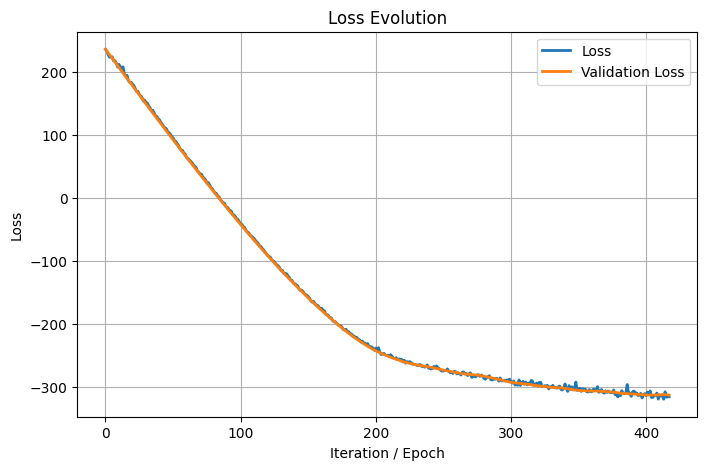

In [10]:
import matplotlib.pyplot as plt
loss_history = output['loss_history']
val_loss = output['val_history']


# Plot            
plt.figure(figsize=(8, 5))
plt.plot(loss_history, label="Loss", linewidth=2)
plt.plot(val_loss, label="Validation Loss", linewidth=2)
plt.xlabel("Iteration / Epoch")
plt.ylabel("Loss")
plt.title("Loss Evolution")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
print(len(output['mu']), sum(p.numel() for p in model.parameters() if p.requires_grad))
print(output['mu'])

150 150
tensor([-9.4935e+00,  1.2790e+00,  1.2864e+00,  1.3214e+00,  1.2826e+00,
         1.9439e+00,  1.3705e+00,  9.8365e-01,  1.6436e+00,  2.0090e+00,
         2.2402e+00,  2.1983e+00, -9.1112e+00,  1.0161e+00,  1.2320e+00,
         1.0501e+00,  1.1660e+00,  1.6477e+00,  7.5029e-01,  8.6961e-01,
         1.9902e+00,  2.4086e+00,  2.4751e+00,  2.4435e+00,  8.0392e-02,
        -5.8261e-02,  6.8337e-04,  6.7399e-02, -8.8858e-02,  1.0078e-02,
        -2.6609e-02, -1.5421e-01, -1.9341e-01, -2.2478e-01,  4.4275e-02,
         3.5285e-02,  6.1925e-02,  1.5083e-01,  2.8582e-01,  2.2097e-01,
         1.3155e-01, -1.1637e-01, -3.8917e-02, -2.8115e-01, -4.2866e-01,
         7.2950e-01,  6.0770e-01,  3.2052e-01,  2.3814e-01,  2.8985e-01,
         3.4884e-01,  4.9306e-01,  2.3948e-01,  2.8175e-01,  9.5698e-02,
         4.0738e-02, -1.6413e-01, -1.8357e-02, -1.8886e-01, -1.8273e-01,
        -1.2589e-01,  1.1049e-01,  1.3221e-01,  1.9767e-02,  5.0967e-02,
        -5.5024e-03,  1.3034e-01,  9.3759e-

In [12]:
import torch

def flat_params(model):
    return torch.cat([p.detach().flatten().cpu() for p in model.parameters()])

# snapshot BEFORE
before = flat_params(model).clone()

model.bayesian_param_set(output, update_buffers=False)
# snapshot AFTER
after = flat_params(model)

max_abs_change = (after - before).abs().max().item()
print(f"Max |Δ| across all parameters: {max_abs_change:.3e}")



Max |Δ| across all parameters: 0.000e+00


In [13]:
# pretrain the marginal transformations
#_ = model.pretrain_transformation_layer(dataloader_train, iterations=1000, max_batches_per_iter=False, penalty_splines_params=penalty_splines_params)

In [14]:
# train the joint model
#_ = model.train(train_dataloader=dataloader_train, validate_dataloader=dataloader_validate, iterations=1000, optimizer="LBFGS",
#                penalty_splines_params=penalty_splines_params, adaptive_lasso_weights_matrix=adaptive_lasso_weights_matrix, penalty_lasso_conditional_independence=penalty_lasso_conditional_independence, 
#                max_batches_per_iter=False)

### 4. Compare to Benchmarks

We compare the learned GTM to a Gaussian Approximation and the Oracle Model. We expect the GTM to lie between these two in terms of approximation the true underlying distribution.
We measure this by means of the Kullback Leibler Divergence which we approximate on the test set which is equivalent to the log likelihood ratio between the true distribution and an approximation of it..

In [15]:
log_likelihood_train_gtm = model.log_likelihood(simulated_data_train)
log_likelihood_validate_gtm = model.log_likelihood(simulated_data_validate)
log_likelihood_test_gtm = model.log_likelihood(simulated_data_test)

In [16]:
# estimate the Multivariate Normal Distribution as Model
mean_mvn_model = simulated_data_train.mean(0)
cov_mvn_model = simulated_data_train.T.cov()
mvn_model = torch.distributions.MultivariateNormal(loc=mean_mvn_model, covariance_matrix=cov_mvn_model)
log_likelihood_train_gaussian = mvn_model.log_prob(simulated_data_train)
log_likelihood_validate_gaussian = mvn_model.log_prob(simulated_data_validate)
log_likelihood_test_gaussian = mvn_model.log_prob(simulated_data_test)


In [17]:
print("KLD GTM      Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gtm).item(),4) )
print("KLD Gaussian Train Data: ",np.round(torch.mean(loglik_true_train - log_likelihood_train_gaussian).item(),4) )
print("KLD Copula   Train Data: ",np.round(torch.mean(loglik_true_train - loglik_true_est_train).item(),4) )

print("KLD GTM      Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gtm).item(),4) )
print("KLD Gaussian Test  Data: ",np.round(torch.mean(loglik_true_test - log_likelihood_test_gaussian).item(),4) )
print("KLD Copula   Test  Data: ",np.round(torch.mean(loglik_true_test - loglik_true_est_test).item(),4) )

KLD GTM      Train Data:  1.1883
KLD Gaussian Train Data:  0.1083
KLD Copula   Train Data:  -0.0015
KLD GTM      Test  Data:  1.149
KLD Gaussian Test  Data:  0.1118
KLD Copula   Test  Data:  0.0051


### 5. Evaluate and Plot GTM Results

We evaluate the model further by showing how to generate synthetic samples, plot the conditional correlation patterns as well as the model splines.

Note that to generate synthetic samples the inverse of the trainsformation layer needs to be approximated  with the method `approximate_transformation_inverse` once which is then stored for future sampling. 

In [18]:
model.approximate_transformation_inverse()
synthetic_samples = model.sample(10000)

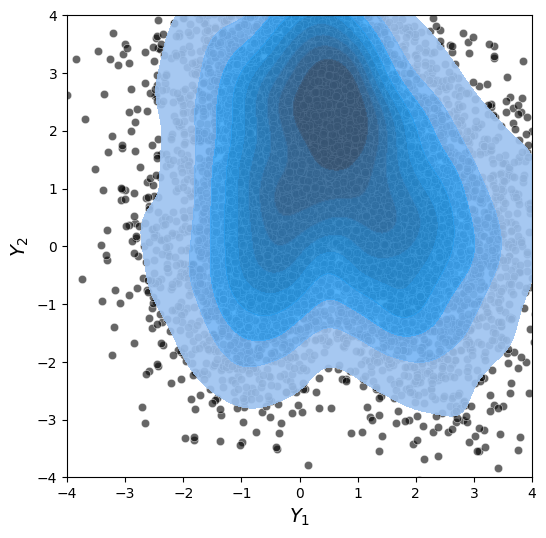

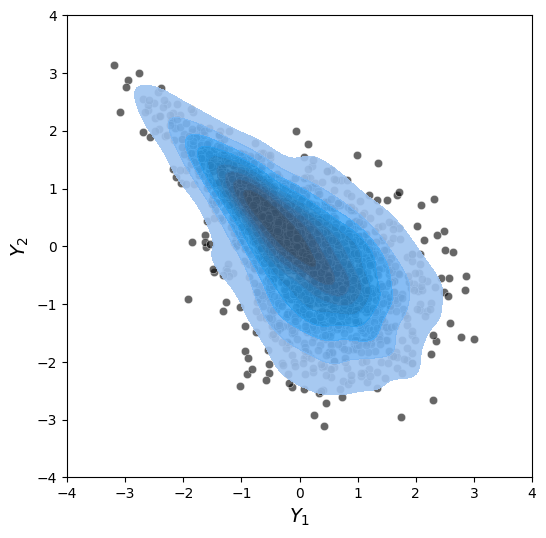

In [19]:
model.plot_densities(synthetic_samples, x_lim=[-4,4], y_lim=[-4,4])
model.plot_densities(simulated_data_train, x_lim=[-4,4], y_lim=[-4,4])

The varying pseudo conditional correlation matrix values can be computed for any synthetic samples using `compute_pseudo_conditional_correlation_matrix` or can directly be plotted using `plot_conditional_dependence_structure`.
The pseudo conditional correlation matrix is the standardised precision matrix so that off diagonal elements are the pseudo conditional correlations between the respective dimensions.

In [20]:
pseudo_conditional_correlation_matrix = model.compute_pseudo_conditional_correlation_matrix(synthetic_samples)

/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/franciscocapunay/miniforge3/envs/gtm-magic-env-3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


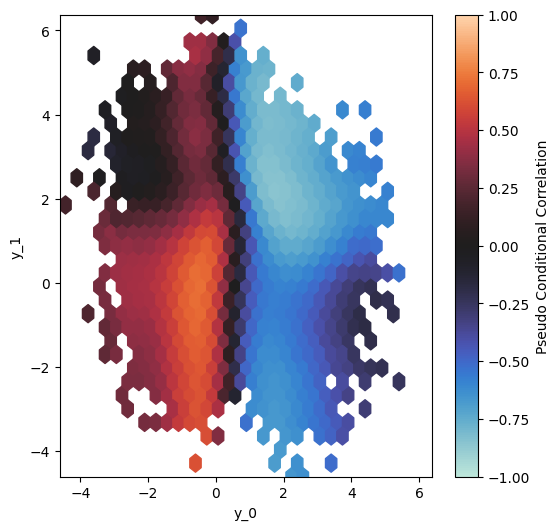

In [21]:
model.plot_conditional_dependence_structure(data=synthetic_samples)

One can also visualize the splines of each layer usign the function `plot_splines`. For the transformation layer we additionally include the dervaitive which is always positive due to the monotonically increasing constraint as well as the inverse which should lie exactly on the spline to visually confirm that the inverse sampling path works.

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:113: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


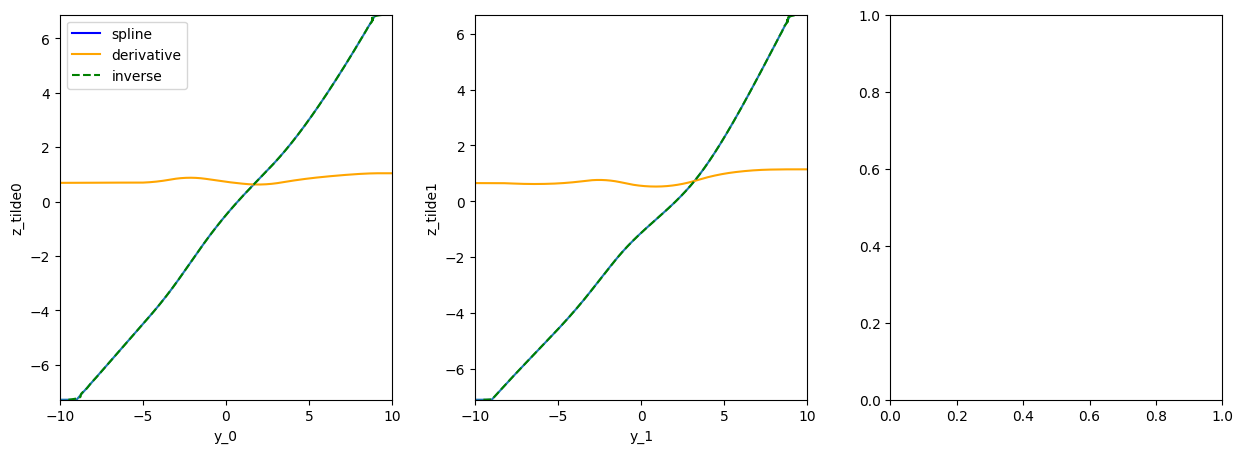

In [22]:
model.plot_splines(layer_type="transformation")

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


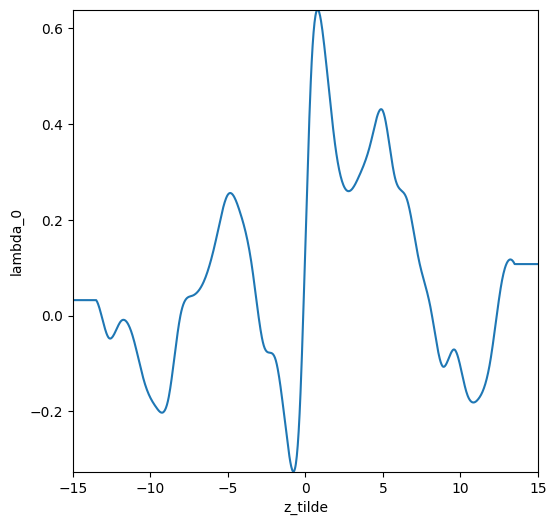

In [23]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=0)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


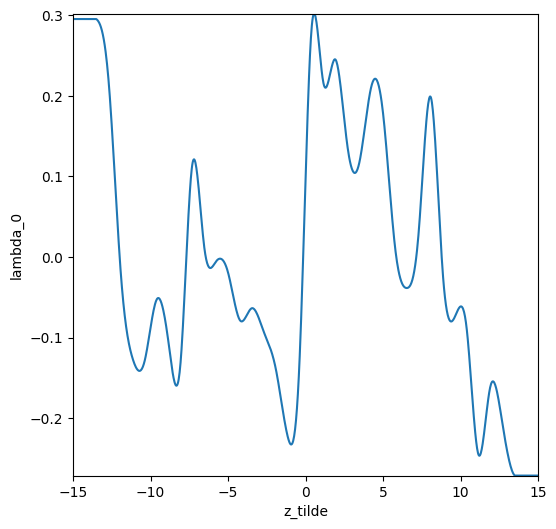

In [24]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=1)

/Users/franciscocapunay/Documents/AkademischeAusbildungLernunterlagen/UniversitaetGoettingen/Studiengänge/MasterAngewandteStatistik/4.Semester/MA/code/gtm/gtm/gtm_plots_analysis/plot_splines.py:250: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = results._append(


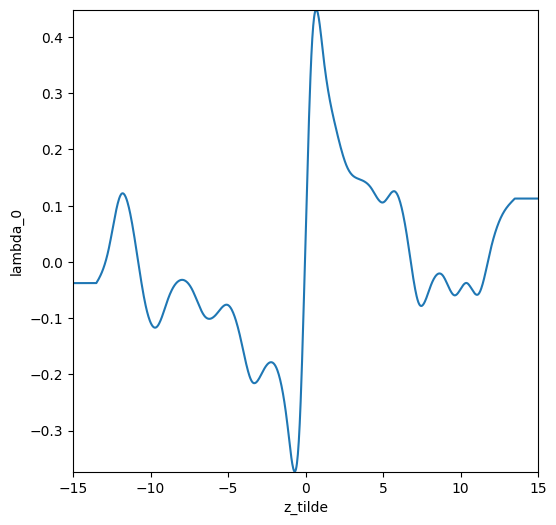

In [25]:
model.plot_splines(layer_type = "decorrelation", decorrelation_layer_number=2)